In [ ]:
from qiskit.circuit import Parameter, QuantumCircuit, ParameterVector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import Pauli
import numpy as np

num_qubits = H_0.num_qubits

def create_parameterized_hamiltonian_ansatz(nqubits, pauli_labels, num_layers, initial_coeffs_values=None, add_classical_bits=True):
    """
    Tạo một Hamiltonian ansatz có tham số U(theta) = product_L (product_k exp(-i * theta_Lk * P_k)).

    Args:
        nqubits (int): Số qubit.
        pauli_labels (list[str]): Danh sách các chuỗi Pauli CỐ ĐỊNH (P_k).
        num_layers (int): Số lớp (N_L) của ansatz.
        initial_coeffs_values (list[float] or np.ndarray, optional): 
                               Giá trị khởi tạo cho các tham số theta. 
                               Nếu num_layers > 1, đây có thể là một mảng 1D dẹt (flattened)
                               hoặc có thể cấu trúc nó theo lớp. 
                               Độ dài phải là len(pauli_labels_fixed) * num_layers.
        add_classical_bits (bool): Nếu True, thêm bit cổ điển.

    Returns:
        qiskit.QuantumCircuit: Mạch lượng tử ansatz có tham số.
        list[Parameter]: Danh sách tất cả các tham số đã tạo (dạng dẹt).
    """
    if not pauli_labels:
        raise ValueError("pauli_labels không được rỗng.")

    if add_classical_bits:
        circuit = QuantumCircuit(nqubits, nqubits)
    else:
        circuit = QuantumCircuit(nqubits)

    total_parameters = len(pauli_labels) * num_layers # Tạo tham số $ \theta_{Lk}$
    params_vector = ParameterVector('θ', total_parameters)
    
    all_parameters_list = list(params_vector) # Danh sách các đối tượng Parameter

    param_idx_counter = 0
    for _ in range(num_layers): # Lặp qua các lớp
        for pauli_str in pauli_labels: # Lặp qua các toán tử Pauli cố định
            if not pauli_str or len(pauli_str) != nqubits:
                raise ValueError(f"Chuỗi Pauli '{pauli_str}' không hợp lệ.")
            
            current_pauli_operator = Pauli(pauli_str)
            # time trong PauliEvolutionGate bây giờ là một Parameter
            param_coeff = params_vector[param_idx_counter]
            param_idx_counter += 1
            
            evolution_gate = PauliEvolutionGate(current_pauli_operator, time=param_coeff) 
            circuit.append(evolution_gate, range(nqubits))
        if num_layers > 1 : # Thêm barrier giữa các lớp nếu có nhiều lớp
            circuit.barrier()
    
    return circuit, all_parameters_list
# 1. Lấy các chuỗi Pauli CỐ ĐỊNH từ Hamiltonian 
# Đây sẽ là CƠ SỞ P_k cho ansatz 
# Có thể lấy chúng từ H_int(T) , hoặc trực tiếp từ H(t)
# nếu các P_k không thay đổi theo thời gian (chỉ có hệ số lambda_j(t) thay đổi).
# Dựa trên H_total1 = Hopt + f(t)*dipole_qubit, các P_k là cố định.

# Lấy labels từ Hopt (phần tĩnh)
static_pauli_op = H_0 
static_labels = static_pauli_op.paulis.to_labels()

# Lấy labels từ dipole_qubit (phần tương tác)
dipole_pauli_op = dipole_qubit
dipole_interaction_labels = dipole_pauli_op.paulis.to_labels()

# Kết hợp danh sách labels và loại bỏ trùng lặp. QUAN TRỌNG: Giữ thứ tự nhất quán.
# Cách tốt nhất là tạo một SparsePauliOp tổng H(t) = H_0 + f(t)*dipole_qubit rồi lấy paulis từ đó.
#  Tuy nhiên, f(t) là số, nên paulis của H(t) sẽ giống paulis của (H_0 + dipole_qubit) nếu không có sự triệt tiêu.
# Để đơn giản, ta có thể lấy một bộ cơ sở Pauli từ H_0 và dipole_qubit.
# Tạo một bộ cơ sở các Pauli strings duy nhất từ cả H_0 và dipole_qubit
# Cách này đảm bảo không trùng lặp và có thứ tự nhất quán nếu dùng dict.fromkeys

combined_unique_labels = list(dict.fromkeys(static_labels + dipole_interaction_labels))
num_qubits = 4

# 2. Tạo Ansatz U(theta)
N = num_qubits # num_qubits = 4
num_ansatz_layers = 1 # Số lớp cho ansatz

# Tạo ansatz và danh sách các tham số có thể tối ưu
# Bây giờ, 'combined_unique_labels' sẽ là P_k cố định 
# và các 'theta_k' sẽ được tạo bên trong hàm này

ansatz_u, optimizable_parameters = create_parameterized_hamiltonian_ansatz(
    nqubits=N,
    pauli_labels=combined_unique_labels,
    num_layers=num_ansatz_layers,
    add_classical_bits=True # Giữ True để nhất quán với target_state nếu nó có clbits
    # initial_coeffs_values có thể được truyền vào optimizer sau
)

print("Ansatz U(theta) được tạo:")
print(ansatz_u.draw(output='text'))
print(f"Số lượng tham số có thể tối ưu: {len(optimizable_parameters)}")
print(f"Các tham số: {optimizable_parameters}")

# --- Hàm ansatz Pennylane ---
from qiskit.quantum_info import Operator
import pennylane as qml
from pennylane import numpy as pnp # Sử dụng numpy của Pennylane
import numpy as np # Numpy gốc
import matplotlib.pyplot as plt
from qiskit.quantum_info import random_unitary
num_qubits_actual = 4 #num_qubits
num_layers_actual = 6 #num_ansatz_layers
constant_error = 1e-6 # Ngưỡng lỗi để dừng tối ưu hóa
def pennylane_ansatz_from_qiskit_pauli_evo(thetas, num_qubits, pauli_labels_fixed, num_layers_ansatz):
    """
Tạo một ansatz Pennylane tương đương với việc áp dụng một chuỗi các PauliEvolutionGate của Qiskit.
Cấu trúc của Qiskit ansatz: U(theta) = product_L (product_k exp(-i * theta_Lk * P_k))
Trong Pennylane, qml.exp(op, coeff) thực hiện exp(coeff * op).
Chúng ta muốn thực hiện exp(-i * theta_Lk * P_k), vậy:
    op = P_k (dưới dạng PauliWord của Pennylane)
    coeff = -1j * theta_Lk

Args:
    thetas (pnp.ndarray): Mảng 1D các tham số theta, được làm phẳng (flattened).
                            Thứ tự phải khớp với cách Qiskit ansatz sử dụng chúng
                            (tức là, tất cả các theta cho lớp 1, sau đó tất cả cho lớp 2, v.v.).
    num_qubits (int): Số qubit của hệ thống.
    pauli_labels_fixed (list[str]): Danh sách các chuỗi Pauli CỐ ĐỊNH (P_k)
                                    dưới dạng chuỗi ký tự kiểu Qiskit (ví dụ: "IXYZ", "ZZI").
                                    Độ dài mỗi chuỗi phải bằng num_qubits.
    num_layers_ansatz (int): Số lớp (N_L) của ansatz.
"""
    if not pauli_labels_fixed:
        raise ValueError("pauli_labels_fixed không được rỗng.")
    
    num_params_per_layer = len(pauli_labels_fixed)
    num_params_expected = num_params_per_layer * num_layers_ansatz

    if len(thetas) != num_params_expected:
        raise ValueError(f"Số lượng tham số `thetas` không khớp. Mong đợi {num_params_expected}, nhận được {len(thetas)}.")
    
    param_idx = 0
    for _ in range(num_layers_ansatz):
        for pauli_qiskit_str in pauli_labels_fixed:
            if len(pauli_qiskit_str) != num_qubits: 
                raise ValueError(f"Chuỗi Pauli '{pauli_qiskit_str}' không khớp num_qubits.")
            
            pennylane_observable = None
            if all(c == 'I' for c in pauli_qiskit_str):
                if num_qubits > 0:
                    pennylane_observable = qml.Identity(0)
                    for i_w in range(1, num_qubits): pennylane_observable @= qml.Identity(i_w)
                elif num_qubits == 0: pennylane_observable = qml.Identity(0)
                else: raise ValueError("Số qubit phải không âm.")
            else:
                try: pennylane_observable = qml.pauli.string_to_pauli_word(pauli_qiskit_str)
                except AttributeError:

                    ops_list = []
                    for i_wire in range(num_qubits):
                        char = pauli_qiskit_str[i_wire]
                        if char == 'X': ops_list.append(qml.PauliX(i_wire))
                        elif char == 'Y': ops_list.append(qml.PauliY(i_wire))
                        elif char == 'Z': ops_list.append(qml.PauliZ(i_wire))
                        elif char == 'I': pass
                        else: raise ValueError(f"Ký tự Pauli không hợp lệ '{char}'")

                    if not ops_list and num_qubits > 0:
                         pennylane_observable = qml.Identity(0)
                         for i_w in range(1, num_qubits): pennylane_observable @= qml.Identity(i_w)
                    elif ops_list: pennylane_observable = qml.prod(*ops_list)
                    else: raise ValueError(f"Không tạo được observable từ '{pauli_qiskit_str}'")
            if pennylane_observable is not None: qml.exp(pennylane_observable, -1j * thetas[param_idx])
            param_idx += 1
# --- Kết thúc hàm ansatz ---

In [ ]:
from qiskit.circuit import Parameter, QuantumCircuit, ParameterVector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import Pauli
import numpy as np

num_qubits = H_0.num_qubits

def create_parameterized_hamiltonian_ansatz(nqubits, pauli_labels, num_layers, initial_coeffs_values=None, add_classical_bits=True):
    """
    Tạo một Hamiltonian ansatz có tham số U(theta) = product_L (product_k exp(-i * theta_Lk * P_k)).

    Args:
        nqubits (int): Số qubit.
        pauli_labels (list[str]): Danh sách các chuỗi Pauli CỐ ĐỊNH (P_k).
        num_layers (int): Số lớp (N_L) của ansatz.
        initial_coeffs_values (list[float] or np.ndarray, optional): 
                               Giá trị khởi tạo cho các tham số theta. 
                               Nếu num_layers > 1, đây có thể là một mảng 1D dẹt (flattened)
                               hoặc có thể cấu trúc nó theo lớp. 
                               Độ dài phải là len(pauli_labels_fixed) * num_layers.
        add_classical_bits (bool): Nếu True, thêm bit cổ điển.

    Returns:
        qiskit.QuantumCircuit: Mạch lượng tử ansatz có tham số.
        list[Parameter]: Danh sách tất cả các tham số đã tạo (dạng dẹt).
    """
    if not pauli_labels:
        raise ValueError("pauli_labels không được rỗng.")
    
    circuit = QuantumCircuit(nqubits)

    total_parameters = len(pauli_labels) * num_layers # Tạo tham số $ \theta_{Lk}$ nhiều lớp thì nhân thêm num_layers
    params_vector = ParameterVector('θ', total_parameters) # \theta_{Lk} là một vector tham số
    
    all_parameters_list = list(params_vector) # Danh sách các đối tượng Parameter

    param_idx_counter = 0   
    for _ in range(num_layers): # Lặp qua các lớp
        for pauli_str in pauli_labels: # Lặp qua các toán tử Pauli cố định
            if not pauli_str or len(pauli_str) != nqubits:
                raise ValueError(f"Chuỗi Pauli '{pauli_str}' không hợp lệ.")
            # Tạo toán tử Pauli từ chuỗi
            current_pauli_operator = Pauli(pauli_str)
            # time trong PauliEvolutionGate bây giờ là một Parameter
            param_coeff = params_vector[param_idx_counter]
            param_idx_counter += 1
            
            evolution_gate = PauliEvolutionGate(current_pauli_operator, time=param_coeff) 
            circuit.append(evolution_gate, range(nqubits))
        if num_layers > 1 : # Thêm barrier giữa các lớp nếu có nhiều lớp
            circuit.barrier()
    
    return circuit, all_parameters_list


In [ ]:
import qiskit

from scipy.linalg import expm
def time_dependent(num_qubits : int , H_total_t,t):
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    for qubit in range(num_qubits//2, num_qubits):
        qc.x(qubit)

    if not np.allclose(H_total_t(t).to_matrix(), np.conj(H_total_t(t).to_matrix()).T):    
        raise ValueError("The Hamiltonian is not Hermitian.")    
    
    time_points = np.linspace(0,t,100)

    # Calculate the integral of H(t) using numerical approximation (e.g., trapezoidal rule)
    integral = np.zeros_like(H_total_t, dtype=complex)

    for i in range(len(time_points) - 1):
        dt = time_points[i+1] - time_points[i]
        integral += (H_total_t(time_points[i]) + H_total_t(time_points[i + 1])) / 2 * dt

   # Compute the matrix exponential
    U = expm(-1j * integral)  

      # Check if U is unitary
    if not np.allclose(U @ U.conj().T, np.eye(U.shape[0])):
        raise ValueError("The resulting matrix U is not unitary.")
        
    #return U matrix
    """
    # Create a UnitaryGate from the unitary_matrix
    unitary_gate = UnitaryGate(U)

    # Append the unitary_gate to the quantum circuit
    qc.append(unitary_gate, range(qc.num_qubits))
    """
    from qoop.core.state import specific_matrix
    
    return specific_matrix(U)
    

def time_dependent_integral(H_total_t, t):
    """create U circuit from h_opt and time t
    
    Args:
        - qc (QuantumCircuit): Init circuit
        - h_opt: Hamiltonian
        - t (float): time
        
    Returns:
        - QuantumCircuit: the added circuit
    """
    # Ensure h_opt is Hermitian
    if not np.allclose((H_total_t(t).to_matrix()), np.conj(H_total_t(t).to_matrix()).T):
        raise ValueError("The Hamiltonian is not Hermitian.")

    time_points = np.linspace(0, t, 100)
    # Calculate the integral of H(t) using numerical approximation (e.g., trapezoidal rule)
    integral = np.zeros_like(H_total_t, dtype=complex)  # Initialize integral as a matrix
    
    for i in range(len(time_points) - 1):
        dt = time_points[i + 1] - time_points[i]
        integral += (H_total_t(time_points[i]) + H_total_t(time_points[i + 1])) / 2 * dt

    return integral    


In [ ]:
from qoop.compilation.qsp import QuantumStatePreparation
p0s = [] 
all_psi_t_approximated = {} 

times_for_qsp = np.linspace(0, 10, 4) 

for t_current in times_for_qsp: 

    target_unitary_at_t_circuit = time_dependent(num_qubits, H_time, t_current)
    target_state_inverse_at_t = target_unitary_at_t_circuit.inverse()

    current_H_int = time_dependent_integral(H_time, t=t_current) 
    initial_point_for_this_t = [] # $\vec{\theta_0}$
    label_to_coeff_map_current_t = dict(zip(current_H_int.paulis.to_labels(), current_H_int.coeffs.real)) # $c_k(t) từ H(t)$
    for _ in range(num_ansatz_layers): # Nếu có nhiều lớp, lặp lại bộ giá trị khởi tạo
        for label in combined_unique_labels:
            initial_point_for_this_t.append(label_to_coeff_map_current_t.get(label, np.random.rand())) # Lấy coeff hoặc ngẫu nhiên 

    qsp_instance = QuantumStatePreparation(
        u=ansatz_u.copy(), # Dùng copy để ansatz_u không bị thay đổi tham số giữa các lần lặp
        target_state=target_state_inverse_at_t
    )
    fit_result = qsp_instance.fit(
        num_steps=300, 
        metrics_func=['loss_basic'],
        initial_point=np.array(initial_point_for_this_t) 
    )
    
    optimal_thetas_at_t_current = qsp_instance.thetas
    # print(f"t = {t_current}, optimal_thetas = {optimal_thetas_at_t_current}")
    
    U_theta_t_current_optimized = ansatz_u.assign_parameters(optimal_thetas_at_t_current)
    # print(U_theta_t_current_matrix)'
    
    U_theta_t_current_matrix = Operator(U_theta_t_current_optimized).data
    psi_0_vqe_col = psi_0_vqe.reshape(-1, 1)
    psi_t_current_col_approx = U_theta_t_current_matrix @ psi_0_vqe_col
    psi_t_current_approx = psi_t_current_col_approx.flatten()
    
    all_psi_t_approximated[t_current] = psi_t_current_approx 

    if 'loss_basic' in fit_result.compiler.metrics:
            p0s.append(1 - fit_result.compiler.metrics['loss_basic'][-1])
    else:
            print(f"Không tìm thấy 'loss_basic' cho time {time}. Keys: {fit_result.compiler.metrics.keys()}")
            p0s.append(0)

print('Fidelity (với ansatz có tham số)', p0s)

In [1]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.operators import PolynomialTensor
from qiskit_nature.second_q.properties import ElectronicDipoleMoment
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC
import numpy as np 
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import COBYLA , SLSQP, L_BFGS_B, SPSA, NELDER_MEAD
from qiskit_algorithms import VQE
from qiskit_algorithms.eigensolvers import NumPyEigensolver
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector
#from qiskit.utils import QuantumInstance

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)
problem = driver.run()
hamiltonian = problem.hamiltonian

dipole: ElectronicDipoleMoment  = problem.properties.electronic_dipole_moment
mapper = JordanWignerMapper()
dipole_ops = dipole.second_q_ops()

# Lấy toán tử moment lưỡng cực từ phương Z (vì X và Y rỗng)
x_dipole_op = dipole_ops["XDipole"]
y_dipole_op = dipole_ops["YDipole"]
z_dipole_op = dipole_ops["ZDipole"]

qubit_dipole_ops = {
    "XDipole": mapper.map(x_dipole_op),
    "YDipole": mapper.map(y_dipole_op),
    "ZDipole": mapper.map(z_dipole_op),
}

qubit_dipole_ops_matrix = {
    "XDipole": qubit_dipole_ops["XDipole"].to_matrix(),
    "YDipole": qubit_dipole_ops["YDipole"].to_matrix(),
    "ZDipole": qubit_dipole_ops["ZDipole"].to_matrix(),
}

second_q_op = hamiltonian.second_q_op()
qubit_jw_op = mapper.map(second_q_op) 


ansatz = UCC(
    num_spatial_orbitals = problem.num_spatial_orbitals, #2
    num_particles = problem.num_particles, # [1, 1]
    excitations='sd',
    qubit_mapper=mapper,
    initial_state=HartreeFock(
        num_spatial_orbitals = problem.num_spatial_orbitals,
        num_particles = problem.num_particles, 
        qubit_mapper=mapper,
    ),
    reps=1,

)

estimator = Estimator()
optimizer = SLSQP(maxiter=200)
vqe = VQE(estimator, ansatz, optimizer)
res = vqe.compute_minimum_eigenvalue(qubit_jw_op)

numpy_solver = NumPyEigensolver()
exact_result = numpy_solver.compute_eigenvalues(qubit_jw_op)
ref_value = exact_result.eigenvalues

H_0 = qubit_jw_op # H_0 (static) dưới dạng SparsePauliOp
H_static = H_0.to_matrix()  # Matrix of 

z_dipole_qubit = qubit_dipole_ops["ZDipole"]  # Toán tử moment lưỡng cực Z dưới dạng SparsePauliOp
z_dipole_matrix = z_dipole_qubit.to_matrix()  # Ma trận của toán tử moment lưỡng cực Z

def Hamilton_SP(t, H_0, z_dipole_qubit, E0, Gamma):
    t_float = float(t)  # Chuyển đổi t sang float 
    E_t = (E0 / np.pi) * Gamma / (Gamma**2 + t_float**2)
    V_t = E_t*z_dipole_qubit
    H_total_q = H_0 + V_t
    return H_total_q

import qiskit

from scipy.linalg import expm
def time_dependent(num_qubits : int , H_total_t,t):
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    for qubit in range(num_qubits//2, num_qubits):
        qc.x(qubit)

    if not np.allclose(H_total_t(t).to_matrix(), np.conj(H_total_t(t).to_matrix()).T):    
        raise ValueError("The Hamiltonian is not Hermitian.")    
    
    time_points = np.linspace(0,t,100)

    # Calculate the integral of H(t) using numerical approximation (e.g., trapezoidal rule)
    integral = np.zeros_like(H_total_t, dtype=complex)

    for i in range(len(time_points) - 1):
        dt = float(time_points[i+1] - time_points[i])
        integral += (H_total_t(time_points[i]) + H_total_t(time_points[i + 1])) / 2 * dt

   # Compute the matrix exponential
    U = expm(-1j * integral)  

      # Check if U is unitary
    if not np.allclose(U @ U.conj().T, np.eye(U.shape[0])):
        raise ValueError("The resulting matrix U is not unitary.")
        
    #return U matrix
    """
    # Create a UnitaryGate from the unitary_matrix
    unitary_gate = UnitaryGate(U)

    # Append the unitary_gate to the quantum circuit
    qc.append(unitary_gate, range(qc.num_qubits))
    """
    # from qoop.core.state import specific_matrix
    
    # return specific_matrix(U)
    return U
    

def time_dependent_integral(H_total_t, t):
    """create U circuit from h_opt and time t
    
    Args:
        - qc (QuantumCircuit): Init circuit
        - h_opt: Hamiltonian
        - t (float): time
        
    Returns:
        - QuantumCircuit: the added circuit
    """
    # Ensure h_opt is Hermitian
    if not np.allclose((H_total_t(t).to_matrix()), np.conj(H_total_t(t).to_matrix()).T):
        raise ValueError("The Hamiltonian is not Hermitian.")

    time_points = np.linspace(0, t, 100)
    # Calculate the integral of H(t) using numerical approximation (e.g., trapezoidal rule)
    integral = np.zeros_like(H_total_t, dtype=complex)  # Initialize integral as a matrix
    
    for i in range(len(time_points) - 1):
        dt = float(time_points[i + 1] - time_points[i])
        integral += (H_total_t(time_points[i]) + H_total_t(time_points[i + 1])) / 2 * dt

    return integral    

def H_time(t):
    Gamma = 0.25
    E0 = 0.01
    return Hamilton_SP(t, H_0, z_dipole_qubit, E0, Gamma)

static_pauli_op = H_0 
static_labels = static_pauli_op.paulis.to_labels()
dipole_pauli_op = z_dipole_qubit
dipole_interaction_labels = dipole_pauli_op.paulis.to_labels()
combined_unique_labels = list(dict.fromkeys(static_labels + dipole_interaction_labels))
num_qubits = H_0.num_qubits
N = num_qubits # num_qubits = 4

circuit = ansatz.assign_parameters(res.optimal_parameters)
psi_0_vqe = np.array(Statevector(circuit).data)


In [2]:
import pennylane as qml
from qiskit.quantum_info import random_unitary
from qiskit.circuit.library import UnitaryGate
from sync import cost as cost_func
from sync import circuit, constant
import pennylane.numpy as np
import pennylane as qml
%load_ext autoreload
%autoreload 2

In [3]:
def pennylane_ansatz_from_qiskit_pauli_evo(thetas, num_qubits, pauli_labels, num_layers):
    """
Tạo một ansatz Pennylane tương đương với việc áp dụng một chuỗi các PauliEvolutionGate của Qiskit.
Cấu trúc của Qiskit ansatz: U(theta) = product_L (product_k exp(-i * theta_Lk * P_k))
Trong Pennylane, qml.exp(op, coeff) thực hiện exp(coeff * op).
Chúng ta muốn thực hiện exp(-i * theta_Lk * P_k), vậy:
    op = P_k (dưới dạng PauliWord của Pennylane)
    coeff = -1j * theta_Lk

Args:
    thetas (np.ndarray): Mảng 1D các tham số theta, được làm phẳng (flattened).
                            Thứ tự phải khớp với cách Qiskit ansatz sử dụng chúng
                            (tức là, tất cả các theta cho lớp 1, sau đó tất cả cho lớp 2, v.v.).
    num_qubits (int): Số qubit của hệ thống.
    pauli_labels (list[str]): Danh sách các chuỗi Pauli CỐ ĐỊNH (P_k)
                                    dưới dạng chuỗi ký tự kiểu Qiskit (ví dụ: "IXYZ", "ZZI").
                                    Độ dài mỗi chuỗi phải bằng num_qubits.
    num_layers (int): Số lớp (N_L) của ansatz.
"""
    if not pauli_labels:
        raise ValueError("pauli_labels không được rỗng.")

    num_params_per_layer = len(pauli_labels)
    num_params_expected = num_params_per_layer * num_layers

    if len(thetas) != num_params_expected:
        raise ValueError(f"Số lượng tham số `thetas` không khớp. Mong đợi {num_params_expected}, nhận được {len(thetas)}.")
    
    param_idx = 0
    for _ in range(num_layers):
        for pauli_qiskit_str in pauli_labels:
            if len(pauli_qiskit_str) != num_qubits:
                raise ValueError(f"Chuỗi Pauli '{pauli_qiskit_str}' không khớp num_qubits.")
            
            pennylane_observable = None
            if all(c == 'I' for c in pauli_qiskit_str):
                if num_qubits > 0:
                    pennylane_observable = qml.Identity(0)
                    for i_w in range(1, num_qubits): pennylane_observable @= qml.Identity(i_w)
                elif num_qubits == 0: pennylane_observable = qml.Identity(0)
                else: raise ValueError("Số qubit phải không âm.")
            else:
                try: pennylane_observable = qml.pauli.string_to_pauli_word(pauli_qiskit_str)
                except AttributeError:

                    ops_list = []
                    for i_wire in range(num_qubits):
                        char = pauli_qiskit_str[i_wire]
                        if char == 'X': ops_list.append(qml.PauliX(i_wire))
                        elif char == 'Y': ops_list.append(qml.PauliY(i_wire))
                        elif char == 'Z': ops_list.append(qml.PauliZ(i_wire))
                        elif char == 'I': pass
                        else: raise ValueError(f"Ký tự Pauli không hợp lệ '{char}'")

                    if not ops_list and num_qubits > 0:
                         pennylane_observable = qml.Identity(0)
                         for i_w in range(1, num_qubits): pennylane_observable @= qml.Identity(i_w)
                    elif ops_list: pennylane_observable = qml.prod(*ops_list)
                    else: raise ValueError(f"Không tạo được observable từ '{pauli_qiskit_str}'")
            if pennylane_observable is not None: qml.exp(pennylane_observable, -1j * thetas[param_idx])
            param_idx += 1
# --- Kết thúc hàm ansatz ---

In [6]:
import math
from numpy.random import Generator, PCG64
import pennylane.numpy as pnp

def constrained_initialization(num_params_per_layer, num_layers, constant=0.1):
    """
    Tạo tham số thetas theo phương pháp Constrained Initialization.
    
    Args:
        num_params_per_layer (int): Số tham số trong một lớp (ví dụ: len(pauli_labels)).
        num_layers (int): Số lớp của ansatz.
        constant (float): Hằng số c trong công thức của bài báo.
        
    Returns:
        pnp.array: Mảng tham số thetas đã được khởi tạo.
    """
    rng = Generator(PCG64())
    num_thetas = num_params_per_layer * num_layers
    
    # Khởi tạo ngẫu nhiên ban đầu
    thetas_np = rng.random(size=num_thetas)
    
    # Áp dụng ràng buộc cho từng lớp
    for i in range(num_layers):
        start_idx = i * num_params_per_layer
        end_idx = (i + 1) * num_params_per_layer
        
        layer_params = thetas_np[start_idx:end_idx]
        
        # Tính tổng các tham số trong lớp này
        param_sum = np.sum(layer_params)
        
        # Nếu tổng khác 0, chuẩn hóa lại theo công thức
        # Lưu ý: Công thức gốc có num_qubits, ở đây ta có thể bỏ qua hoặc điều chỉnh
        # vì thetas của chúng ta là góc quay, không phải thời gian.
        # Ta có thể đơn giản ràng buộc tổng của chúng bằng một hằng số nhỏ.
        if param_sum > 1e-9:
            normalization_factor = (constant * math.pi) / param_sum
            thetas_np[start_idx:end_idx] *= normalization_factor
            
    return pnp.array(thetas_np, requires_grad=True)

# --- Cách sử dụng trong ô code f65fe2b6 của bạn ---
# Bạn sẽ thay thế dòng khởi tạo thetas hiện tại bằng hàm này

# ... (code định nghĩa num_layers, pauli_labels...)
num_params_per_layer = len(combined_unique_labels)
num_layers = 6
# Thay vì: thetas = pnp.array(...)
# Bạn sẽ dùng:
thetas = constrained_initialization(num_params_per_layer, num_layers, constant=0.1)

# ... (phần còn lại của vòng lặp for t in times:)

In [7]:
import math
from qiskit.quantum_info import Operator
import pennylane as qml
from numpy.random import Generator, PCG64
#from pennylane import numpy as pnp 
import numpy as np
import pennylane.numpy as pnp
import matplotlib.pyplot as plt
from qiskit.quantum_info import random_unitary

num_qubits = H_0.num_qubits #num_qubits
num_layers = 6 #num_ansatz_layers
#constant_error = 1e-6 


pauli_labels = combined_unique_labels
num_thetas = len(pauli_labels) * num_layers

# num_blocks = num_qubits*(num_qubits-1)//2
# active_blocks =  np.ones(num_blocks * num_layers)
# thetas ban đầu
# if num_thetas > 0:
#     thetas = pnp.array(np.random.uniform(0, 2*np.pi, num_thetas), requires_grad=True)
# else:
#     thetas = pnp.array([], requires_grad=False)
rng = Generator(PCG64())  
#args = parser.parse_args()
#thetas = np.random.uniform(0, 2*np.pi, constant.num_params_on_active_blocks(active_blocks), requires_grad=True)
#thetas = np.random.uniform(0,2*np.pi,num_thetas,requires_grad=True)

# Phương pháp random 
thetas = constrained_initialization(num_params_per_layer, num_layers, constant=0.1)

# Phương pháp small random
# thetas = pnp.array(args.small*rng.random(size = num_thetas), requires_grad=True)

#Phương pháp constrained initialization

times = np.linspace(0, 100, 20)

# Danh sách lưu trữ
all_optimized_U_theta_t = {}
all_psi_t_pennylane = {}
#all_costs_history_per_t = {}
frobenius_norms_over_time = {} 


print("Bắt đầu mô phỏng tiến hóa thời gian bằng Pennylane")
for t in times:
    print(f"\n--- Thời điểm t = {t:.4f} ---")

    target = time_dependent(num_qubits, H_time, t)
    
    def cost(thetas): 
        ansatz_matrix = qml.matrix(pennylane_ansatz_from_qiskit_pauli_evo,
                                   wire_order=list(range(num_qubits)) 
                                  )(
                                      thetas,
                                      num_qubits,
                                      pauli_labels,
                                      num_layers
                                  )
        return cost_func.c_hst(ansatz_matrix, target)

    steps = 300
    costs = []
    opt = qml.AdamOptimizer(stepsize=0.01)
    
    for n in range(steps):
        thetas, prev_cost = opt.step_and_cost(cost, thetas)
        if (n + 1) % (steps // 2 if steps >=2 else 1) == 0: 
            print(f"    t={t:.2f}, Opt. step {n+1}/{steps}, Cost: {prev_cost:.6f}")
        if prev_cost < constant.error:
                print(f"    Đạt ngưỡng lỗi ở bước {n+1} cho t={t:.2f}")
               # break
        costs.append(prev_cost)

    U_theta_t = None
    if num_thetas > 0:
        U_theta_t = qml.matrix(pennylane_ansatz_from_qiskit_pauli_evo,
                                            wire_order=range(num_qubits) #if num_qubits > 0 else [0]
                                           )(
                                               thetas, 
                                               num_qubits,
                                               pauli_labels,
                                               num_layers
                                           )
    elif num_qubits > 0:
        U_theta_t = np.eye(2**num_qubits, dtype=complex)
    else:
        U_theta_t = np.array([[1.0+0.j]])


    all_optimized_U_theta_t[t] = U_theta_t.numpy() if hasattr(U_theta_t, 'numpy') else np.asarray(U_theta_t)

    norm_diff = np.linalg.norm(U_theta_t - target, 'fro')
    frobenius_norms_over_time[t] = norm_diff
    # Công thức: F(A, B) = sqrt(Tr((A-B)^H * (A-B)))
    # diff_dm = dm_exact - dm_approx
    #frobenius_dist = qml.math.norm(diff_dm, ord='fro')
    # frobenius_dist = qml.math.sqrt(qml.math.real(qml.math.trace(qml.math.dot(qml.math.conj(qml.math.transpose(diff_dm)), diff_dm))))
    # all_frobenius_distances[t] = frobenius_dist

    print(f"  Frobenius Norm ||U(θ*) - V(t)|| = {norm_diff:.6e}")

    if num_qubits >= 0 : 
        psi_0_col = psi_0_vqe.reshape(-1, 1)
        U_mat_np_for_psi = all_optimized_U_theta_t[t]       

        psi_t_col_approx = U_mat_np_for_psi @ psi_0_col
        psi_t_approx = psi_t_col_approx.flatten()
        all_psi_t_pennylane[t] = psi_t_approx




Bắt đầu mô phỏng tiến hóa thời gian bằng Pennylane

--- Thời điểm t = 0.0000 ---
    Đạt ngưỡng lỗi ở bước 64 cho t=0.00
    Đạt ngưỡng lỗi ở bước 65 cho t=0.00
    Đạt ngưỡng lỗi ở bước 66 cho t=0.00
    Đạt ngưỡng lỗi ở bước 67 cho t=0.00
    Đạt ngưỡng lỗi ở bước 68 cho t=0.00
    Đạt ngưỡng lỗi ở bước 69 cho t=0.00
    Đạt ngưỡng lỗi ở bước 70 cho t=0.00
    Đạt ngưỡng lỗi ở bước 71 cho t=0.00
    Đạt ngưỡng lỗi ở bước 72 cho t=0.00
    Đạt ngưỡng lỗi ở bước 73 cho t=0.00
    Đạt ngưỡng lỗi ở bước 74 cho t=0.00
    Đạt ngưỡng lỗi ở bước 75 cho t=0.00
    Đạt ngưỡng lỗi ở bước 76 cho t=0.00
    Đạt ngưỡng lỗi ở bước 77 cho t=0.00
    Đạt ngưỡng lỗi ở bước 78 cho t=0.00
    Đạt ngưỡng lỗi ở bước 79 cho t=0.00
    Đạt ngưỡng lỗi ở bước 80 cho t=0.00
    Đạt ngưỡng lỗi ở bước 81 cho t=0.00
    Đạt ngưỡng lỗi ở bước 82 cho t=0.00
    Đạt ngưỡng lỗi ở bước 83 cho t=0.00
    Đạt ngưỡng lỗi ở bước 84 cho t=0.00
    Đạt ngưỡng lỗi ở bước 85 cho t=0.00
    Đạt ngưỡng lỗi ở bước 86 cho t=0.00

In [9]:
from qiskit.quantum_info import Operator
all_psi_t_exact = {} 

times = np.linspace(0,100,20)

for t in times:

    U_true_at_t_circuit = time_dependent(num_qubits, H_time, t)
    U_true_at_t_matrix = Operator(U_true_at_t_circuit).data
    
    psi_0_vqe_col = psi_0_vqe.reshape(-1,1)
    psi_t_current_col_exact = U_true_at_t_matrix @ psi_0_vqe_col
    psi_t_current_exact = psi_t_current_col_exact.flatten()
    
    all_psi_t_exact[t] = psi_t_current_exact

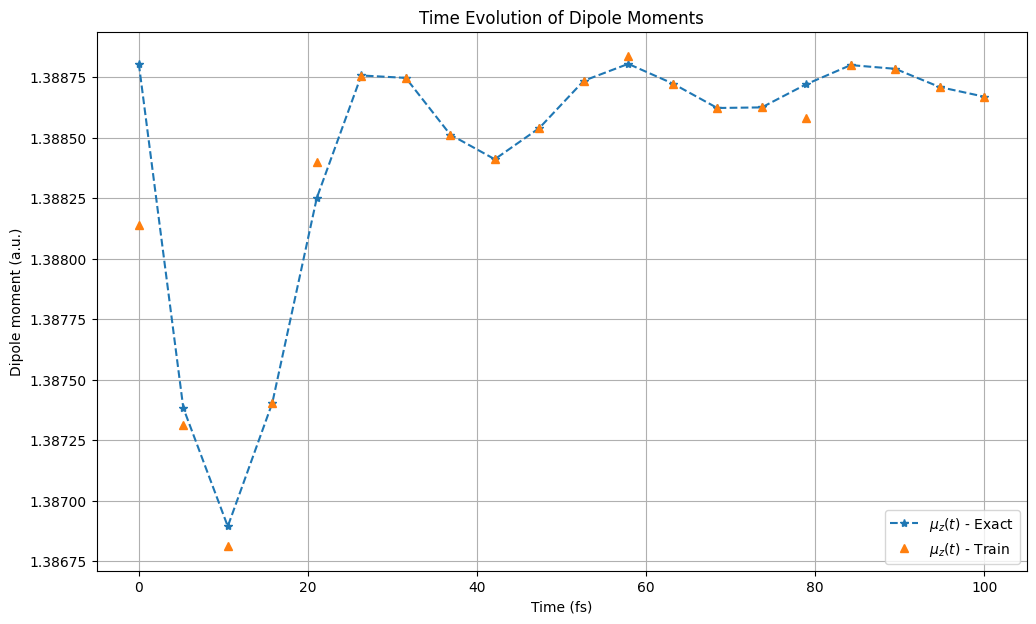

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp 
import qiskit 

def calculate_expectation_value(state_vector_flat, pauli_op_sparse):
    if pauli_op_sparse is None or state_vector_flat is None:
        return np.nan
    sv = Statevector(state_vector_flat)
    try:
        exp_val = sv.expectation_value(pauli_op_sparse)
        return exp_val.real 
    except Exception as e_exp:
        print(f"    Lỗi khi tính giá trị kỳ vọng: {e_exp}")
        return np.nan

times_plot_exact = []
mux_plot_exact = []
muy_plot_exact = []
muz_plot_exact = []

times_plot_pennylane = []
mux_plot_pennylane = []
muy_plot_pennylane = []
muz_plot_pennylane = []

# Pennylane
sorted_times_pennylane = sorted(all_psi_t_pennylane.keys())

for t_current in sorted_times_pennylane:
    psi_t_pennylane = all_psi_t_pennylane[t_current]

    if psi_t_pennylane is not None:
        # print(f"  Tính toán cho t = {t_current:.4f} (Pennylane)") 
        times_plot_pennylane.append(t_current)
        mux_plot_pennylane.append(calculate_expectation_value(psi_t_pennylane, x_dipole_qubit if 'dipole_qubit_X' in locals() and x_dipole_qubit is not None else None))
        muy_plot_pennylane.append(calculate_expectation_value(psi_t_pennylane, y_dipole_qubit if 'dipole_qubit_Y' in locals() and y_dipole_qubit is not None else None))
        muz_plot_pennylane.append(calculate_expectation_value(psi_t_pennylane, z_dipole_qubit))
    else:
        times_plot_pennylane.append(t_current)
        mux_plot_pennylane.append(np.nan)
        muy_plot_pennylane.append(np.nan)
        muz_plot_pennylane.append(np.nan)

times_pennylane = np.array(times_plot_pennylane)
mux_pennylane = np.array(mux_plot_pennylane)
muy_pennylane = np.array(muy_plot_pennylane)
muz_pennylane = np.array(muz_plot_pennylane)

# Exact
sorted_times = sorted(all_psi_t_exact.keys())

for t_current in sorted_times:
    psi_t = all_psi_t_exact[t_current]
    
    if psi_t is not None: 
        times_plot_exact.append(t_current)

        current_mux = calculate_expectation_value(psi_t, x_dipole_qubit if 'dipole_qubit_X' in locals() and x_dipole_qubit is not None else None)
        current_muy = calculate_expectation_value(psi_t, y_dipole_qubit if 'dipole_qubit_Y' in locals() and y_dipole_qubit is not None else None)
        current_muz = calculate_expectation_value(psi_t, z_dipole_qubit) 

        mux_plot_exact.append(current_mux)
        muy_plot_exact.append(current_muy)
        muz_plot_exact.append(current_muz)
    else:

        times_plot_exact.append(t_current)
        mux_plot_exact.append(np.nan)
        muy_plot_exact.append(np.nan)
        muz_plot_exact.append(np.nan)

times_exact = np.array(times_plot_exact)
mux_exact = np.array(mux_plot_exact)
muy_exact = np.array(muy_plot_exact)
muz_exact = np.array(muz_plot_exact)

plt.figure(figsize=(12, 7))

# Vẽ đường "Exact" 
if  mux_exact.size > 0 and np.any(~np.isnan(mux_exact)) and np.any(mux_exact != 0):
    plt.plot(times_exact, mux_exact, label="$\mu_x(t)$ - Exact", marker='x', linestyle='--')
if muy_exact.size > 0 and np.any(~np.isnan(muy_exact)) and np.any(muy_exact != 0):
    plt.plot(times_exact, muy_exact, label="$\mu_y(t)$ - Exact", marker='+', linestyle='--')
if muz_exact.size > 0 and np.any(~np.isnan(muz_exact)):
    plt.plot(times_exact, muz_exact, label="$\mu_z(t)$ - Exact", marker='*', linestyle='--')

# Vẽ đường từ kết quả Pennylane
if mux_pennylane.size > 0 and np.any(~np.isnan(mux_pennylane)) and np.any(mux_pennylane != 0):
    plt.plot(times_pennylane, mux_pennylane, label="$\mu_x(t)$ - Train", marker='o', linestyle='-')
if muy_pennylane.size > 0 and np.any(~np.isnan(muy_pennylane)) and np.any(muy_pennylane != 0):
    plt.plot(times_pennylane, muy_pennylane, label="$\mu_y(t)$ - Train", marker='s', linestyle='-')
if muz_pennylane.size > 0 and np.any(~np.isnan(muz_pennylane)):
    plt.plot(times_pennylane, muz_pennylane, label="$\mu_z(t)$ - Train", marker='^', linestyle='')

plt.xlabel("Time (fs)")
plt.ylabel("Dipole moment (a.u.)")
plt.title("Time Evolution of Dipole Moments")


handles, labels = plt.gca().get_legend_handles_labels()
if labels:
    plt.legend()
    
#plt.xlim(0,300)
plt.grid(True)
plt.show()
